# Expectation Maximisation on Mixture Model

We model $Y$ as a mixture of two normal distirbutions, with parameters $\theta = \{\pi, \mu_1, \sigma_1, \mu_2, \sigma_2\}$:

$$
\begin{align} 
Y_1 &\sim N(\mu_1 , \sigma_1^2 ) \\
Y_2 &\sim N(\mu_2 , \sigma_2^2 ) \\
Y &= (1 - \Delta) \cdot Y_1 + \Delta \cdot Y_2
\end{align}$$

where $\Delta = \{0,1\}$ and $P(\Delta = 1) = \pi$

Following is the `pdf` of $Y$

$$p(x|\theta) = \left( 
\frac{1-\pi}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(\hat{y} - \mu_1)^2} {2 \sigma_1^2}}\right) 
+ \frac{\pi}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(\hat{y} - \mu_2)^2} {2 \sigma_2^2}}\right) 
\right)$$

The parameter of $Y$ is $\theta = \left\{ \pi, \mu_1, \sigma_1^2, \mu_2, \sigma_2^2 \right\}$

In [1]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Ground truth

The parameters $\theta = \{\mu_1, \sigma_1, \mu_2, \sigma_2, \pi\}$ that is used to generate the set of samples.

In [2]:
pi_true = 0.8  # probability if it lies from normal distribution 2 
mean_1_true = 1.
stde_1_true = 1.0
mean_2_true = 4.
stde_2_true = 0.8

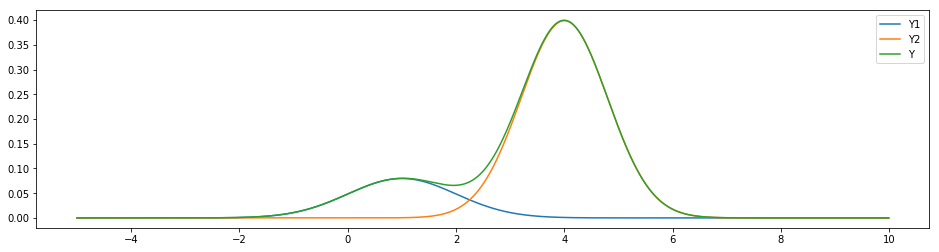

In [3]:
# plotting the pdf
import numpy as np
import matplotlib.pyplot as plt

plot_range = np.arange(-5,10,0.01)
pdf_Y1 = [((1.-pi_true)/(np.sqrt(2.*np.pi*stde_1_true**2.))) * 
          np.exp(-(x - mean_1_true)**2. / (2.*stde_1_true**2)) for x in plot_range]
pdf_Y2 = [(pi_true/(np.sqrt(2.*np.pi*stde_2_true**2.))) * 
          np.exp(-(x - mean_2_true)**2. / (2.*stde_2_true**2)) for x in plot_range]
pdf_Y = np.add(pdf_Y1,pdf_Y2)

plt.figure(figsize=(16,4))
plt.plot(plot_range,pdf_Y1, label="Y1")
plt.plot(plot_range,pdf_Y2, label="Y2")
plt.plot(plot_range,pdf_Y, label="Y")
plt.legend(loc="best")
plt.show()

# Generating samples
We shall generate some samples $\mathbf{X}$ given the "true" parameters. 

We will then find the best parameter $\theta$ that fit into this model, in other words, maximise the expectation given the parameters  $\theta = \{\mu_1, \sigma_1, \mu_2, \sigma_2, \pi\}$ .

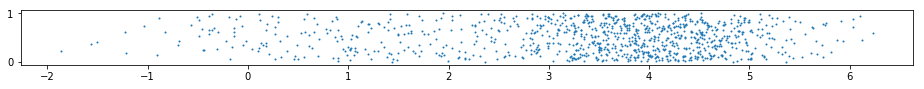

In [4]:
l = 1000
dot_size = 1.

samples = [stde_1_true*np.random.randn() + mean_1_true
           if np.random.random() > pi_true 
           else stde_2_true*np.random.randn() + mean_2_true
           for _ in range(l)]

plt.figure(figsize=(16,1))
plt.scatter(samples,np.random.random(l),s=dot_size)
plt.show()

Plotting histogram of samples

In [5]:
def plot_hist_pdf(samples_, pi_, mean_1_, mean_2_, stde_1_, stde_2_):
    plt.figure(figsize=(16,2))
    pdf_Y1 = [((1.-pi_)/(np.sqrt(2.*np.pi*stde_1_**2.))) * 
            np.exp(-(x - mean_1_)**2. / (2.*stde_1_**2)) for x in plot_range]
    pdf_Y2 = [(pi_/(np.sqrt(2.*np.pi*stde_2_**2.))) * 
            np.exp(-(x - mean_2_)**2. / (2.*stde_2_**2)) for x in plot_range]
    pdf_Y = np.add(pdf_Y1,pdf_Y2)
    plt.hist(samples, normed=True, bins=plot_range, color="orange")
    plt.plot(plot_range,pdf_Y1, label="Y1")
    plt.plot(plot_range,pdf_Y2, label="Y2")
    plt.plot(plot_range,pdf_Y, label="Y")
    plt.show()
    print("pi = {:.4f}, mean_1 = {:.4f}, mean_2 = {:.4f}, stde_1 = {:.4f}, stde_2 = {:.4f}"
      .format(pi_,mean_1_,mean_2_,stde_1_,stde_2_))
    
# making histograms take time
# https://stackoverflow.com/questions/44003552/matplotlib-histogram-from-numpy-histogram-output
# but this doesn't seem to be faster

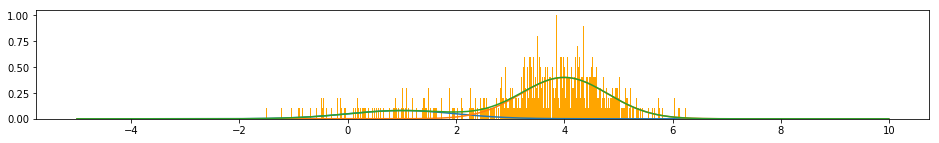

pi = 0.8000, mean_1 = 1.0000, mean_2 = 4.0000, stde_1 = 1.0000, stde_2 = 0.8000


In [6]:
plot_hist_pdf(samples, pi_true, mean_1_true, mean_2_true, stde_1_true, stde_2_true)

# Maximising w.r.t. $\{p, \mu_1, \sigma_1, \mu_2, \sigma_2\}$ 

We want to maximise the expectation with respect to $\{p , \mu_1, \sigma_1, \mu_2, \sigma_2\}$:

$$\prod_i \left( 
\frac{1-p}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(\hat{x}_i - \mu_1)^2} {2 \sigma_1^2}}\right) 
+ \frac{p}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(\hat{x}_i - \mu_2)^2} {2 \sigma_2^2}}\right) 
\right) $$

We hope to maximize the log likelihood:

$$\log P(\mathbf{X} | \theta) = \ell(\theta | \mathbf{X}) = \sum_i log\left( 
\frac{1-p}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(\hat{x}_i - \mu_1)^2} {2 \sigma_1^2}}\right) 
+ \frac{p}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(\hat{x}_i - \mu_2)^2} {2 \sigma_2^2}}\right) 
\right) $$

We now calcalate log-likelihood w.r.t. ground truth for future reference.

In [7]:
def calc_nll(samples, pi_, mean_1_, mean_2_, stde_1_, stde_2_):
    l_ = len(samples)
    return -np.sum(
            np.log(
                (1-pi_)/(stde_1_*np.sqrt(2*np.pi))
                  *np.exp(-np.power(np.add(samples,[-mean_1_]*l_),2))/(2*stde_1_**2)
                + (pi_/(stde_2_*np.sqrt(2*np.pi)))
                  *np.exp(-np.power(np.add(samples,[-mean_2_]*l_),2))/(2*stde_2_**2)))

nll_true = calc_nll(samples, pi_true, mean_1_true, mean_2_true, stde_1_true, stde_2_true)

print("nll_true = {}".format(nll_true))

nll_true = 2174.06002335


The direct maximisation of $\ell(\theta,\mathbf{X})$ is "quite difficult numerically, because of the sum of terms inside the logarithm". Therefore we define a function $\ell {\left( \theta\right | \mathbf{X}, \mathbf{Z})}$ that is equal at $\theta = \theta_0$ but lower then $\ell(\theta | \mathbf{X})$ everywhere else. The interpretation of the $\mathbf{Z}$ is a vector of hidden variables taking values 0 or 1 that guesses which of $Y_1$ or $Y_2$ does each sample $x$ come from. If $z = 0$ then that sample comes from $Y_1$, if $z = 1$ then that sample comes from $Y_2$.

If we are given a vector $\mathbf(Z)$ of hidden variables, the expression becomes:

$$\log P(\mathbf{X} | \theta, \mathbf{Z}) = \ell(\theta, \mathbf{Z} | \mathbf{X}) = \sum_i log\left( 
\frac{1- z_i}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(\hat{x}_i - \mu_1)^2} {2 \sigma_1^2}}\right) 
+ \frac{z_i}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(\hat{x}_i - \mu_2)^2} {2 \sigma_2^2}}\right) 
\right) $$

Practically speaking, this then becomes the addition of the log likelihoods of exactly two different distributions, as we know exactly which distribution each sample comes from.




## Insertion of Hidden Variables
We first observe that we can insert the hidden variables $z$ through the law of total probability.

$$
\begin{align} 
\log P(\mathbf{X} | \theta) &= \sum_i log P(x_i| \theta)   \\
&= \sum_i log\left(\sum_z P(x_i|z,\theta)P(z|\theta)\right) \\
&= \sum_i log\left( P(x_i|z =0,\theta)P(z=0|\theta) + P(x_i|z =1,\theta)P(z=1|\theta)\right)\\
\end{align}$$


This corresponds to
$$
\begin{align} 
\log P(\mathbf{X} | \theta) &= \sum_i log\left( \sum_z \left(
\frac{1- z}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(\hat{x}_i - \mu_1)^2} {2 \sigma_1^2}}\right) 
+ \frac{z}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(\hat{x}_i - \mu_2)^2} {2 \sigma_2^2}}\right) \right) \cdot P(z|\theta)
\right) \\
&= \sum_i log\left( \left(
\frac{1- 0}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(\hat{x}_i - \mu_1)^2} {2 \sigma_1^2}}\right)\right)\cdot P(z= 0) 
+ \left(\frac{1}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(\hat{x}_i - \mu_2)^2} {2 \sigma_2^2}}\right) \cdot P(z=1) \right)
\right) \\ 
&= \sum_i log\left( 
\frac{(1-p)}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(\hat{x}_i - \mu_1)^2} {2 \sigma_1^2}}\right) 
+ \frac{(p)}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(\hat{x}_i - \mu_2)^2} {2 \sigma_2^2}}\right)
\right)
\end{align}$$

This simplification shows us that the insertion of the hidden variables stil makes the expression mathematically equal to our $\log P(\mathbf{X} | \theta)$ expression at first.

## Derivation of $log P(\mathbf{X} | \mathbf{Z}, \theta)$

The form of $log P(\mathbf{X},\mathbf{Z} | \theta)$ is required in the Expectation step. It has been derived in the EM tutorial (and will be derived later) to be needed to find the next iteration of $\theta$. Hence, we want to find the form of $log P(\mathbf{X},\mathbf{Z} | \theta)$.

$$
\begin{align} 
\log P(\mathbf{X} ,\mathbf{Z} | \theta) &= \sum_i log P(x_i, z_i| \theta)   \\
&= \sum_i log\left( P(x_i|z_i,\theta)P(z_i|\theta)\right) \\
\end{align}$$

We observe that $P(z_i|\theta)$ refers to simply $(1-p)$ when $p=0$ or $p$ when $p = 1$. 

$$
\begin{align} 
\log P(\mathbf{X} ,\mathbf{Z}| \theta) &= \sum_i log \left(
\left(\frac{1- z_i}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(\hat{x}_i - \mu_1)^2} {2 \sigma_1^2}}\right)\cdot (1-p)\right) 
+ \left(\frac{z_i}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(\hat{x}_i - \mu_2)^2} {2 \sigma_2^2}}\right)\cdot(p)\right)
\right) \\
&= \sum_i log\left( 
\frac{(1- z_i)(1-p)}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(\hat{x}_i - \mu_1)^2} {2 \sigma_1^2}}\right) 
+ \frac{(z_i)(p)}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(\hat{x}_i - \mu_2)^2} {2 \sigma_2^2}}\right)
\right)\\
&= \sum_i \left( (1- z_i)log\left(
\frac{(1-p)}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(\hat{x}_i - \mu_1)^2} {2 \sigma_1^2}}\right) \right)
+ (z_i)log\left(\frac{(p)}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(\hat{x}_i - \mu_2)^2} {2 \sigma_2^2}}\right)\right)
\right)
\end{align}$$

The last step, which involves taking the indicator variables $(1- z_i)$ or $(z_i)$ outside the logarithm terms, holds as the expansion of the terms are equal.

## Maximization step for $\theta_{n+1}$

From the EM tutorial, we see a way of iteration is to find a $\theta_{n+1}$ such that:

$$
\begin{align} 
\theta_{n+1} = argmax \left(\sum_z P(z|\mathbf{X}, \theta_n)\cdot log P(\mathbf{X},z |\theta) \right) \\
\end{align}$$

The expression for $log P(\mathbf{X},z |\theta)$ has been found above. We think of $P(z|\mathbf{X}, \theta_n)$ as the responsibility, $\gamma$. 

Interpretation for $\gamma_i$: given current model $\theta_n$, $\gamma_i$ is the probability that the $i$th sample belongs to $Y_2$ rather than $Y_1$. 

$$\gamma_i(\theta_n) = E\left(z_i | \theta_n, \mathbf{X}\right) = Pr\left(z_i = 1 | \theta_n, \mathbf{X}\right) $$

$$ {\gamma}_i = \frac{p_n \phi_{Y_2,n} ( x_i )}{(1 - p_n) \phi_{Y_1,n} ( x_i ) + p_n \phi_{Y_2,n} ( x_i )} $$

Combining both the expressions we have found above and the responsibilities, we get:

$$
\begin{align} 
\theta_{n+1} &= argmax \left(\sum_i \gamma_{i,n} \cdot log(p \cdot \phi_{Y_2}(x_i)) + (1 -\gamma_{i,n}) \cdot log((1-p) \cdot \phi_{Y_1}(x_i)) \right) \\
&= argmax \left(\sum_i \frac{p_n \phi_{Y_2,n} ( x_i )}{(1 - p_n) \phi_{Y_1,n} ( x_i ) + p_n \phi_{Y_2,n} ( x_i )} \cdot log(p \cdot \phi{Y_2}(x_i)) + (1 -\frac{p_n \phi_{Y_2,n} ( x_i )}{(1 - p_n) \phi_{Y_1,n} ( x_i ) + p_n \phi_{Y_2,n} ( x_i )}) \cdot log((1-p) \cdot \phi{Y_1}(x_i)) \right) \\
\end{align}$$



# EM algorithm

## Initial parameters
We will need to start from a set of parameters to begin our parameters from. Perhaps we should use something that is reasonable. The initial mean for each of the distribution value should be slightly different from one another so they can start diverging.

$$\begin{align}
\hat{\mu}_1 &= +\epsilon + \frac{1}{N} \sum_{i=1}^N x_i \\
\hat{\sigma}_1 &= \sqrt{\frac{1}{N-1} \sum_{i=1}^N  (x_i - \hat{\mu}_2)^2} \\
\hat{\mu}_2 &= - \epsilon + \frac{1}{N} \sum_{i=1}^N x_i \\
\hat{\sigma}_2 &= \sqrt{\frac{1}{N-1} \sum_{i=1}^N  (x_i - \hat{\mu}_2)^2} \\
\hat{\pi} &= 0.5 
\end{align}$$

In [8]:
# # the five parameters
pi = 0.5  # probability if it lies from 
mean_1 = np.mean(samples) - np.std(samples)
stde_1 = np.std(samples) 
mean_2 = np.mean(samples) + np.std(samples)
stde_2 = np.std(samples)

# pi = 0.8  # probability if it lies from 
# mean_1 = 2.1
# stde_1 = 1.1
# mean_2 = 4.1
# stde_2 = 3.81

## Expectation Step

Interpretation for $\gamma_i$: given current model $\theta$, $\gamma_i$ is the probability that the sample belongs to $\theta_2$ rather than $\theta_1$

$$\gamma_i(\theta) = E\left(z_i | \theta, \mathbf{X}\right) = Pr\left(z_i = 1 | \theta, \mathbf{X}\right) $$

$$ \hat{\gamma}_i = \frac{
\hat{p} \phi_{\hat{\theta}_2} ( x_i )
}{
(1 - \hat{p}) \phi_{\hat{\theta}_1} ( x_i ) + \hat{p} \phi_{\hat{\theta}_2} ( x_i )
} $$

## Maximisation Step
With $\{y_i\}$, we can find the maximum of $\ell_0\left(\mathbf{Z},\Delta|\theta\right)$ 

```Updating the model (don't know how this is derived)```


$$\begin{align}
\hat{\mu}_1 &= \frac{
\sum_{i=1}^N (1 - \hat{\gamma}_i) x_i
}{
\sum_{i=1}^N (1 - \hat{\gamma}_i)
} \\
\hat{\sigma}_1 &= \frac{
\sum_{i=1}^N (1 - \hat{\gamma}_i) (x_i - \hat{\mu}_2)^2
}{
\sum_{i=1}^N (1 - \hat{\gamma}_i)
} \\
\hat{\mu}_2 &= \frac{
\sum_{i=1}^N \hat{\gamma}_i x_i
}{
\sum_{i=1}^N \hat{\gamma}_i
} \\
\hat{\sigma}_2 &= \frac{
\sum_{i=1}^N \hat{\gamma}_i (x_i - \hat{\mu}_2)^2
}{
\sum_{i=1}^N \hat{\gamma}_i
} 
\end{align}$$

($\hat{\gamma}_i$ is analgous to $L_i$ with Numford's book)

# Iterations
We will do many iterations, and see their result.

In [9]:
# pi = 0.5  # probability if it lies from 
# mean_1 = 1.1
# stde_1 = 0.4
# mean_2 = 5.
# stde_2 = 1.55

In [10]:
pi_list = [pi]
mean_1_list = [mean_1]
stde_1_list = [stde_1]
mean_2_list = [mean_2]
stde_2_list = [stde_2]
nll = calc_nll(samples, pi, mean_1, mean_2, stde_1, stde_2)
nll_list = [nll]

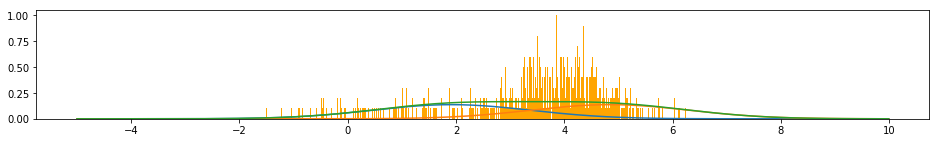

pi = 0.5000, mean_1 = 1.9160, mean_2 = 4.8364, stde_1 = 1.4602, stde_2 = 1.4602
interation 0, nll = 4353.90279674


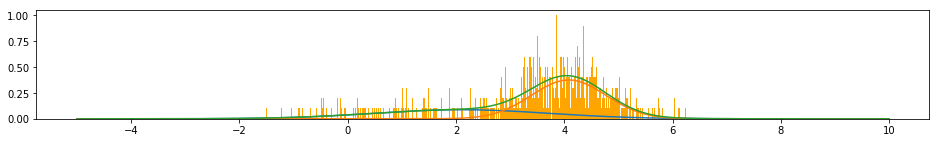

pi = 0.6451, mean_1 = 2.0941, mean_2 = 4.0816, stde_1 = 1.6135, stde_2 = 0.6864
interation 10, nll = 2422.56192979


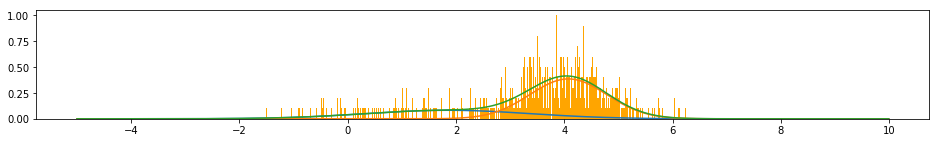

pi = 0.6867, mean_1 = 1.8487, mean_2 = 4.0733, stde_1 = 1.5160, stde_2 = 0.7112
interation 20, nll = 2346.11622256


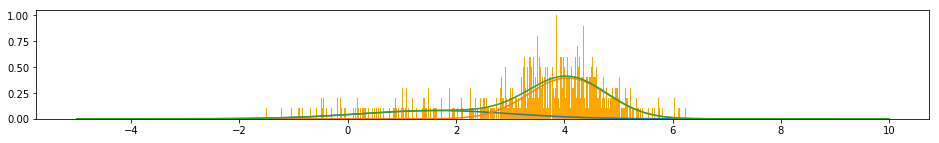

pi = 0.7184, mean_1 = 1.6304, mean_2 = 4.0604, stde_1 = 1.4084, stde_2 = 0.7266
interation 30, nll = 2268.23230514


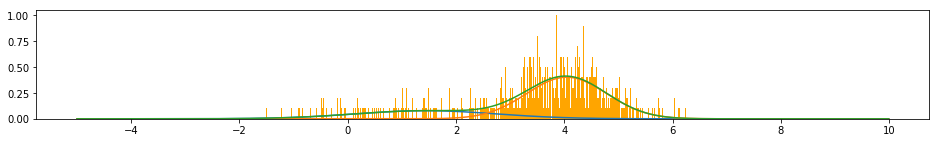

pi = 0.7440, mean_1 = 1.4385, mean_2 = 4.0429, stde_1 = 1.3033, stde_2 = 0.7384
interation 40, nll = 2203.7311911


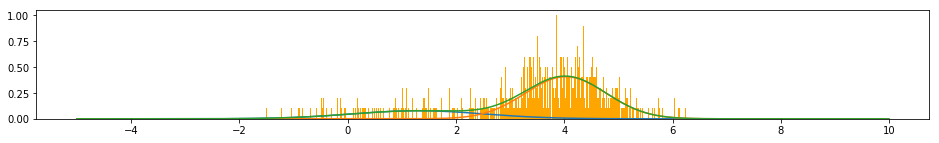

pi = 0.7621, mean_1 = 1.2964, mean_2 = 4.0256, stde_1 = 1.2211, stde_2 = 0.7484
interation 50, nll = 2165.44865772


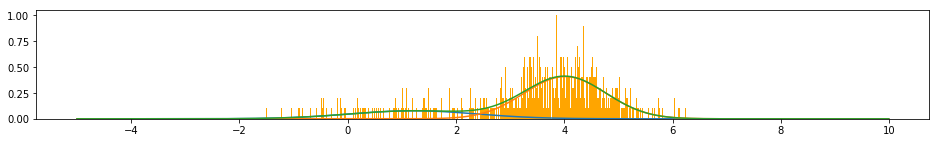

pi = 0.7726, mean_1 = 1.2116, mean_2 = 4.0134, stde_1 = 1.1709, stde_2 = 0.7557
interation 60, nll = 2149.00908032


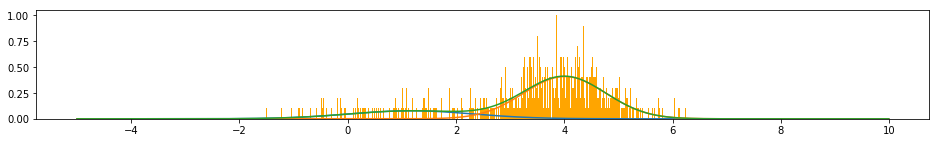

pi = 0.7778, mean_1 = 1.1691, mean_2 = 4.0067, stde_1 = 1.1456, stde_2 = 0.7599
interation 70, nll = 2143.11675077


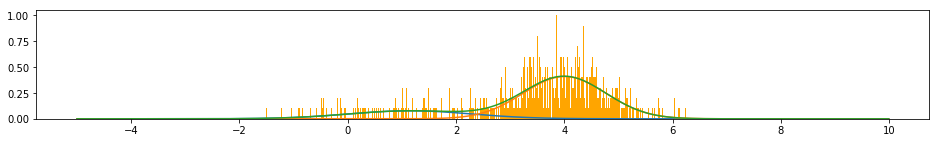

pi = 0.7802, mean_1 = 1.1499, mean_2 = 4.0035, stde_1 = 1.1341, stde_2 = 0.7619
interation 80, nll = 2141.04635217


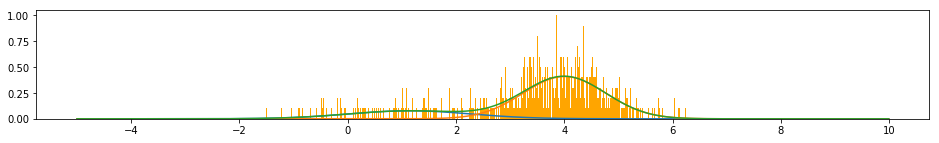

pi = 0.7812, mean_1 = 1.1417, mean_2 = 4.0022, stde_1 = 1.1292, stde_2 = 0.7628
interation 90, nll = 2140.27875014


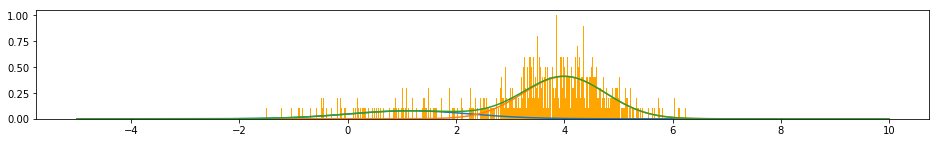

pi = 0.7816, mean_1 = 1.1383, mean_2 = 4.0016, stde_1 = 1.1271, stde_2 = 0.7632
interation 100, nll = 2139.97919233


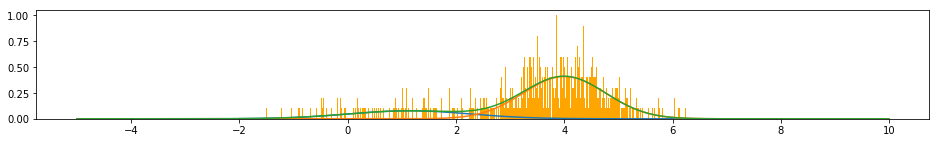

pi = 0.7818, mean_1 = 1.1368, mean_2 = 4.0013, stde_1 = 1.1263, stde_2 = 0.7633
interation 110, nll = 2139.85877445


In [11]:
iterations = 120
plotting = False
for x in range(iterations):
    
    if x%10 == 0:
        plot_hist_pdf(samples, pi, mean_1, mean_2, stde_1, stde_2)
        print("interation {}, nll = {}".format(x, nll))
    
    odds_Y1 = [((1-pi)/(stde_1*np.sqrt(2*np.pi))) 
                * np.exp(-(x - mean_1)**2. / (2. * stde_1**2)) for x in samples]
    odds_Y2 = [((pi)/(stde_2*np.sqrt(2*np.pi))) 
                * np.exp(-(x - mean_2)**2. / (2. * stde_2**2)) for x in samples]
    gamma_i = np.divide(odds_Y2,np.add(odds_Y1,odds_Y2))
    gamma_1_i = np.divide(odds_Y1,np.add(odds_Y1,odds_Y2))
    
    pi = np.sum(gamma_i)/l
    mean_1 = np.sum(np.multiply(gamma_1_i,samples)) / np.sum(gamma_1_i)
    mean_2 = np.sum(np.multiply(gamma_i,samples)) / np.sum(gamma_i)
    stde_1 = np.sqrt(np.sum(np.multiply(gamma_1_i,
                            np.power(np.add(samples,[-mean_1]*l),2)))/np.sum(gamma_1_i))
    stde_2 = np.sqrt(np.sum(np.multiply(gamma_i,
                            np.power(np.add(samples,[-mean_2]*l),2)))/np.sum(gamma_i))

    
    pi_list.append(pi)
    mean_1_list.append(mean_1)
    stde_1_list.append(stde_1)
    mean_2_list.append(mean_2)
    stde_2_list.append(stde_2)
    nll = calc_nll(samples, pi, mean_1, mean_2, stde_1, stde_2)
    nll_list.append(nll)
    


Statistics on the rate of decrease of nll

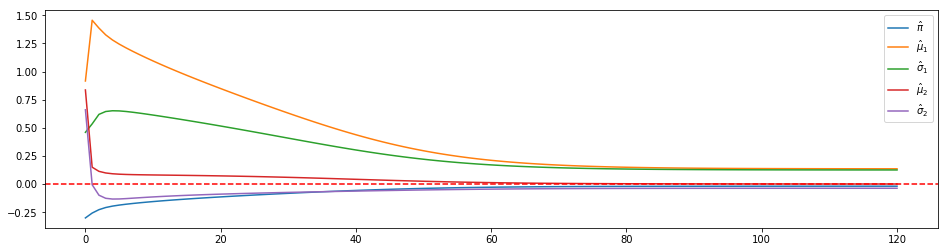

In [15]:
plt.figure(figsize=(16,4))
plt.plot(np.add(pi_list,-pi_true), label="$\hat{\pi}$")
plt.plot(np.add(mean_1_list,-mean_1_true), label="$\hat{\mu}_1$")
plt.plot(np.add(stde_1_list,-stde_1_true), label="$\hat{\sigma}_1$")
plt.plot(np.add(mean_2_list,-mean_2_true), label="$\hat{\mu}_2$")
plt.plot(np.add(stde_2_list,-stde_2_true), label="$\hat{\sigma}_2$")
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(loc="best")
plt.show()

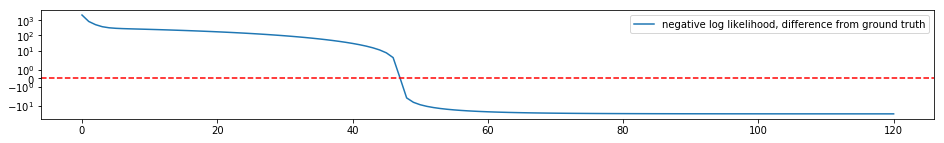

In [16]:
plt.figure(figsize=(16,2))
plt.plot(nll_list-nll_true, label="negative log likelihood, difference from ground truth")
plt.legend(loc="best")
plt.yscale('symlog')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

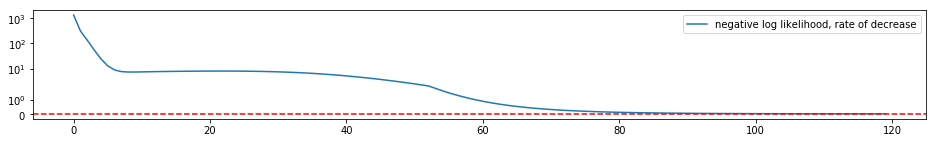

In [17]:
plt.figure(figsize=(16,2))
plt.plot(-np.diff(nll_list), 
             label="negative log likelihood, rate of decrease")
plt.legend(loc="best")
plt.yscale('symlog')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()